In [9]:
# ===================================================================
# Cell 1: Setup and Imports
# ===================================================================
import pandas as pd
import numpy as np
import os
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# For TabPFN Model
from tabpfn import TabPFNClassifier
from sklearn.metrics import f1_score

# --- Installation Note ---
# !pip install tabpfn sklearn pandas seaborn matplotlib tqdm

print("Setup Complete!")

Setup Complete!


In [10]:
# ===================================================================
# Cell 2: The Core Engine - Modified SOM (iSOM) Class (MULTICLASS VERSION)
# ===================================================================
from sklearn.preprocessing import LabelBinarizer

class ModifiedSOM:
    """
    MULTICLASS VERSION of the Modified Self-Organizing Map (iSOM).
    It handles a categorical target by one-hot encoding the labels and learning
    a probability distribution for each prototype.
    """
    def __init__(self, x_dim, y_dim, n_iterations=100, learning_rate=0.5):
        self.x_dim, self.y_dim = x_dim, y_dim
        self.n_nodes = x_dim * y_dim
        self.n_iterations = n_iterations
        self.alpha_0 = learning_rate
        self._data_mean, self._data_std = None, None
        self.weights = None
        self.n_features, self.k_classes = None, None
        self.label_binarizer = LabelBinarizer()

    def _initialize_weights(self, data):
        self.weights = np.zeros((self.x_dim, self.y_dim, data.shape[1]))
        if data.shape[0] < 2:
            self.weights = np.random.rand(self.x_dim, self.y_dim, data.shape[1])
            return
        cov_matrix = np.cov(data, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        valid_eigens = eigenvalues.real > 1e-9
        eigenvalues, eigenvectors = eigenvalues[valid_eigens].real, eigenvectors[:, valid_eigens].real
        sorted_indices = np.argsort(eigenvalues)[::-1]

        if eigenvectors.shape[1] >= 2:
            principal_components = eigenvectors[:, sorted_indices[:2]]
            grid_x, grid_y = np.meshgrid(np.linspace(-1, 1, self.x_dim), np.linspace(-1, 1, self.y_dim))
            for i in range(self.x_dim):
                for j in range(self.y_dim):
                    vec = grid_x[j, i] * principal_components[:, 0] + grid_y[j, i] * principal_components[:, 1]
                    self.weights[i, j] = vec * np.std(data, axis=0) + np.mean(data, axis=0)
        elif eigenvectors.shape[1] == 1:
            principal_component = eigenvectors[:, sorted_indices[0]]
            grid_scalars = np.linspace(-1, 1, self.n_nodes)
            flat_weights = self.weights.reshape(-1, data.shape[1])
            for i in range(self.n_nodes):
                vec = grid_scalars[i] * principal_component
                flat_weights[i] = vec * np.std(data, axis=0) + np.mean(data, axis=0)
            self.weights = flat_weights.reshape(self.x_dim, self.y_dim, data.shape[1])
        else:
            self.weights = np.random.rand(self.x_dim, self.y_dim, data.shape[1])
                
    def _find_bmu(self, x_sample):
        input_weights = self.weights[:, :, :self.n_features]
        distances = np.linalg.norm(input_weights - x_sample, axis=2)
        return np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        # *** CHANGE FOR MULTICLASS: One-hot encode the target labels ***
        y_one_hot = self.label_binarizer.fit_transform(y)
        self.k_classes = y_one_hot.shape[1]
        
        full_data = np.hstack((X, y_one_hot))
        self._data_mean, self._data_std = np.mean(full_data, axis=0), np.std(full_data, axis=0)
        self._data_std[self._data_std == 0] = 1
        normalized_data = (full_data - self._data_mean) / self._data_std
        X_norm, y_norm = normalized_data[:, :self.n_features], normalized_data[:, self.n_features:]
        
        self._initialize_weights(normalized_data)
        
        p, t_max = len(X_norm), self.n_iterations
        total_steps, C, sigma_0 = p * t_max, p / 100.0, max(self.x_dim, self.y_dim) / 2.0
        grid_coords = np.indices((self.x_dim, self.y_dim)).transpose(1, 2, 0)
        
        for t in range(t_max):
            for i in range(p):
                s = t * p + i
                bmu_coords = self._find_bmu(X_norm[i])
                sigma_s, L_s = sigma_0 * (1 - s / total_steps), C * (self.alpha_0 / (C + s))
                dist_to_bmu = np.linalg.norm(grid_coords - bmu_coords, axis=2)
                phi_s = np.exp(-dist_to_bmu**2 / (2 * sigma_s**2))

                # *** CHANGE FOR MULTICLASS: Update target vector and feature vector ***
                target_error = y_norm[i] - self.weights[:, :, self.n_features:]
                feature_error = X_norm[i] - self.weights[:, :, :self.n_features]
                
                self.weights[:, :, self.n_features:] += L_s * phi_s[:, :, np.newaxis] * target_error
                self.weights[:, :, :self.n_features] += L_s * phi_s[:, :, np.newaxis] * feature_error

    def get_prototypes(self):
        if self.weights is None: raise RuntimeError("Call .fit() first.")
        prototypes_norm = self.weights.reshape(-1, self.n_features + self.k_classes)
        # Denormalize
        prototypes_denorm = prototypes_norm * self._data_std + self._data_mean
        
        # Separate features and target probabilities
        features = prototypes_denorm[:, :self.n_features]
        target_probs = prototypes_denorm[:, self.n_features:]
        
        # Apply softmax to ensure probabilities sum to 1
        target_probs_exp = np.exp(target_probs)
        target_probs_softmax = target_probs_exp / np.sum(target_probs_exp, axis=1, keepdims=True)
        
        return features, target_probs_softmax

In [11]:
# ===================================================================
# Cell 3: RoI-Focused Synthetic Data Generator (MULTICLASS VERSION)
# ===================================================================
def generate_isom_data_roi_multiclass(df_real, target_column, num_synthetic_total):
    """
    MULTICLASS VERSION of the RoI-focused data generator.
    Identifies the RoI as prototypes with high uncertainty (low confidence) and
    generates balanced, high-quality synthetic data.
    """
    if num_synthetic_total <= 0: return pd.DataFrame(columns=df_real.columns)
    
    print(f"Generating {num_synthetic_total} MULTICLASS RoI-focused synthetic samples...")
    
    X, y = df_real.drop(columns=[target_column]).values, df_real[target_column].values
    k_classes = len(df_real[target_column].unique())
    # Confidence threshold: slightly above random guess
    confidence_threshold = (1 / k_classes) + 0.2 
    
    num_prototypes = max(len(df_real) * 3, num_synthetic_total)
    map_x, map_y = int(np.sqrt(num_prototypes)), int(num_prototypes / int(np.sqrt(num_prototypes)))
    if map_x == 0 or map_y == 0: return pd.DataFrame(columns=df_real.columns)

    # 1. Train the multiclass iSOM
    isom = ModifiedSOM(x_dim=map_x, y_dim=map_y, n_iterations=100)
    isom.fit(X, y)

    # 2. Identify the Region of Interest based on UNCERTAINTY
    features, target_probs = isom.get_prototypes()
    confidence = np.max(target_probs, axis=1)
    
    # RoI = prototypes where the model is not confident in its prediction
    roi_indices = np.where(confidence < confidence_threshold)[0]
    
    if len(roi_indices) < k_classes:
        print(f"Warning: RoI is too small ({len(roi_indices)} samples). Falling back to all prototypes.")
        roi_features, roi_probs = features, target_probs
    else:
        roi_features, roi_probs = features[roi_indices], target_probs[roi_indices]
        print(f"Identified {len(roi_features)} prototypes in the Region of Interest.")

    # 3. Generate balanced samples from the RoI
    all_synthetic_samples = []
    unique_classes = sorted(df_real[target_column].unique())
    n_samples_per_class = num_synthetic_total // len(unique_classes)
    rng = np.random.default_rng(42)

    for class_label in unique_classes:
        # Generate samples for this class by drawing from the RoI prototypes
        # and assigning the target class label.
        indices = rng.choice(len(roi_features), size=n_samples_per_class, replace=True)
        
        # Take features from the RoI and add noise
        new_features = roi_features[indices]
        noise = rng.normal(0, 0.02 * np.std(X, axis=0))
        new_features += noise
        
        # Combine features with the target class label
        new_labels = np.full((n_samples_per_class, 1), class_label)
        all_synthetic_samples.append(np.hstack([new_features, new_labels]))
    
    # Create final DataFrame
    final_df = pd.DataFrame(np.vstack(all_synthetic_samples), columns=df_real.columns)
    final_df[target_column] = final_df[target_column].astype(int)
    return final_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
# ===================================================================
# Cell 4: Helper Functions (Data Loading)
# ===================================================================

def read_data(path):
    _, ext = os.path.splitext(path)
    if ext == ".parquet": return pd.read_parquet(path)
    elif ext == ".csv": return pd.read_csv(path, index_col=0)

def load_data(base_path, dataset_name):
    with open(os.path.join(base_path, dataset_name, f"{dataset_name}.meta.json")) as f: meta = json.load(f)
    train_data = read_data(os.path.join(base_path, dataset_name, f"{dataset_name}.{meta['format']}"))
    
    test_path = os.path.join(base_path, dataset_name, f"{dataset_name}_test.{meta['format']}")
    if os.path.exists(test_path):
        print(f"Found dedicated test set for {dataset_name}.")
        test_data = read_data(test_path)
    else:
        print(f"No dedicated test set for {dataset_name}. Splitting will be handled by index file.")
        test_data = None
        
    return train_data, test_data, meta

def get_indices_for_repeat(base_path, dataset_name, repeat_idx):
    train_idx_file = os.path.join(base_path, dataset_name, "train_indices.parquet")
    train_idx_splits = pd.read_parquet(train_idx_file)
    col_name = train_idx_splits.columns[repeat_idx]
    return train_idx_splits[col_name].values

In [13]:
# ===================================================================
# Cell 5: Main Configuration
# ===================================================================
BASE_DATA_PATH = "data"
DATASETS_TO_RUN = [
    "framed_safety"
]
REPEATS = 3

# --- Experiment Parameters ---
STARTING_REAL_FRACTIONS = [0.1, 0.3, 0.5]
POOL_TRAINING_FRACTIONS = [0.2, 0.4, 0.6, 0.8, 1.0]
BASELINE_REAL_FRACTIONS = np.arange(0.1, 1.1, 0.1).round(1)

In [14]:
# ===================================================================
# Cell 6: Main Experiment Loop
# ===================================================================
all_results = []
# The public TabPFN version has a limit of 1024 data points for training.
TABPFN_TRAINING_LIMIT = 10000
classifier = TabPFNClassifier(device="cuda")

for dataset_name in tqdm(DATASETS_TO_RUN, desc="Overall Dataset Progress"):
    print(f"\n===== Running Dataset: {dataset_name} =====")
    
    full_train_data, test_data_from_file, meta = load_data(BASE_DATA_PATH, dataset_name)
    y_column = meta["label"]

    # # Binarize the target if it's continuous
    # if pd.api.types.is_float_dtype(full_train_data[y_column]):
    #     threshold = full_train_data[y_column].median()
    #     full_train_data[y_column] = (full_train_data[y_column] <= threshold).astype(int)
    #     if test_data_from_file is not None:
    #         test_data_from_file[y_column] = (test_data_from_file[y_column] <= threshold).astype(int)

    X_columns = full_train_data.columns.drop(y_column)
    full_train_size = len(full_train_data)

    for i in range(REPEATS):
        shuffled_indices = get_indices_for_repeat(BASE_DATA_PATH, dataset_name, i)
        
        if test_data_from_file is not None:
            X_test, y_test = test_data_from_file[X_columns], test_data_from_file[y_column]
        else:
            train_idx_for_split, test_idx_for_split = np.split(shuffled_indices, [int(0.8 * len(shuffled_indices))])
            X_test, y_test = full_train_data.loc[test_idx_for_split, X_columns], full_train_data.loc[test_idx_for_split, y_column]

        # --- Baseline Experiment ---
        for real_fraction in tqdm(BASELINE_REAL_FRACTIONS, desc=f"Repeat {i+1} Baseline", leave=False):
            n_real = int(real_fraction * full_train_size)
            if n_real < 2: continue
            train_indices = shuffled_indices[:n_real]
            
            X_train, y_train = full_train_data.loc[train_indices, X_columns], full_train_data.loc[train_indices, y_column].astype(int)

            if len(X_train) > TABPFN_TRAINING_LIMIT:
                X_train = X_train.sample(n=TABPFN_TRAINING_LIMIT, random_state=i)
                y_train = y_train.loc[X_train.index]
            
            classifier.fit(X_train, y_train)
            y_pred = classifier.predict(X_test)
            score = f1_score(y_test.astype(int), y_pred, average="macro")
            all_results.append({"dataset": dataset_name, "experiment": "Baseline (Real Only)", "total_fraction": real_fraction, "f1_score": score})

        # --- Augmentation Experiment ---
        for start_fraction in tqdm(STARTING_REAL_FRACTIONS, desc=f"Repeat {i+1} Augmentation", leave=False):
            n_real = int(start_fraction * full_train_size)
            if n_real < 2: continue
            real_subset = full_train_data.loc[shuffled_indices[:n_real]]
            
            n_synthetic = full_train_size - n_real
            
            # ** THIS IS THE KEY CHANGE: Calling the new RoI-focused generator **
            synthetic_data = generate_isom_data_roi_multiclass(real_subset, y_column, n_synthetic)
            
            data_pool = pd.concat([real_subset, synthetic_data]).sample(frac=1, random_state=i)
            
            for pool_fraction in POOL_TRAINING_FRACTIONS:
                n_pool_samples = int(pool_fraction * len(data_pool))
                if n_pool_samples < 2: continue
                training_subset_from_pool = data_pool.head(n_pool_samples)
                X_train, y_train = training_subset_from_pool[X_columns], training_subset_from_pool[y_column].astype(int)
                
                if len(X_train) > TABPFN_TRAINING_LIMIT:
                    X_train = X_train.sample(n=TABPFN_TRAINING_LIMIT, random_state=i)
                    y_train = y_train.loc[X_train.index]
                
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_test)
                score = f1_score(y_test.astype(int), y_pred, average="macro")
                all_results.append({"dataset": dataset_name, "experiment": f"Start {int(start_fraction*100)}% Real (RoI)", "f1_score": score, "total_fraction": pool_fraction})

results_df = pd.DataFrame(all_results)
results_df.to_csv("final_roi_experiment_results.csv", index=False)
print("\n\n===== ALL EXPERIMENTS COMPLETE! Results saved to 'final_roi_experiment_results.csv' =====")

Overall Dataset Progress:   0%|          | 0/1 [00:00<?, ?it/s]


===== Running Dataset: framed_safety =====
No dedicated test set for framed_safety. Splitting will be handled by index file.


Repeat 1 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 1 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 3642 MULTICLASS RoI-focused synthetic samples...
Identified 3600 prototypes in the Region of Interest.
Generating 2833 MULTICLASS RoI-focused synthetic samples...
Identified 3600 prototypes in the Region of Interest.
Generating 2023 MULTICLASS RoI-focused synthetic samples...
Identified 6006 prototypes in the Region of Interest.


Repeat 2 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 2 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 3642 MULTICLASS RoI-focused synthetic samples...
Identified 3600 prototypes in the Region of Interest.
Generating 2833 MULTICLASS RoI-focused synthetic samples...
Identified 3600 prototypes in the Region of Interest.
Generating 2023 MULTICLASS RoI-focused synthetic samples...
Identified 6006 prototypes in the Region of Interest.


Repeat 3 Baseline:   0%|          | 0/10 [00:00<?, ?it/s]

Repeat 3 Augmentation:   0%|          | 0/3 [00:00<?, ?it/s]

Generating 3642 MULTICLASS RoI-focused synthetic samples...
Identified 3600 prototypes in the Region of Interest.
Generating 2833 MULTICLASS RoI-focused synthetic samples...
Identified 3600 prototypes in the Region of Interest.
Generating 2023 MULTICLASS RoI-focused synthetic samples...
Identified 6006 prototypes in the Region of Interest.


===== ALL EXPERIMENTS COMPLETE! Results saved to 'final_roi_experiment_results.csv' =====


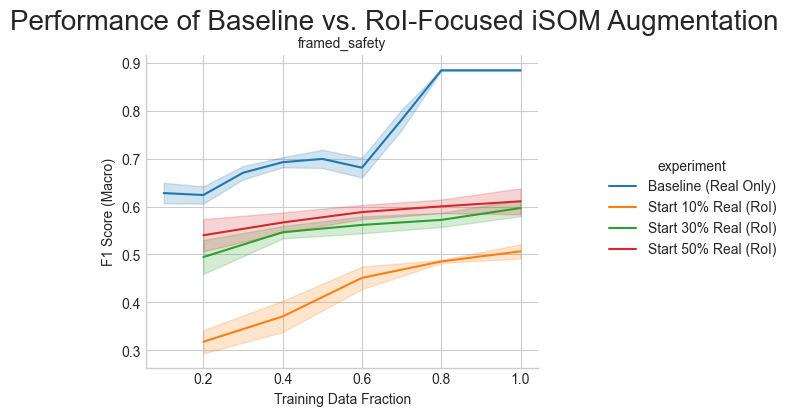

In [15]:
# ===================================================================
# Cell 7: Visualize All Results
# ===================================================================
plt.style.use('seaborn-v0_8-whitegrid')

# Ensure the results dataframe is loaded if running this cell independently
# results_df = pd.read_csv("final_roi_experiment_results.csv")

experiment_order = ["Baseline (Real Only)"] + [f"Start {int(f*100)}% Real (RoI)" for f in STARTING_REAL_FRACTIONS]

g = sns.FacetGrid(
    results_df, 
    col="dataset", 
    col_wrap=1, 
    hue="experiment",
    # style="experiment",  # Define style here
    hue_order=experiment_order,
    # style_order=experiment_order, # Match the style order
    col_order=DATASETS_TO_RUN,
    height=4, 
    aspect=1.2, 
    sharey=False,
    legend_out=True # Ensures legend is placed neatly
)

g.map_dataframe(
    sns.lineplot,
    x="total_fraction",
    y="f1_score",
    markers=True,
    errorbar="sd"
).set_titles("{col_name}")

g.set_axis_labels("Training Data Fraction", "F1 Score (Macro)")
g.fig.suptitle("Performance of Baseline vs. RoI-Focused iSOM Augmentation", y=1.03, fontsize=20)
g.add_legend()

# Save the figure before showing
plt.savefig("final_roi_experiment_results.png", dpi=300, bbox_inches='tight')
plt.show()

